# Treinamento DistilRoBERTa - Fake News Classification - PS Ligia NLP  
**Autor:** Carlos Eduardo Falcão Teixeira (ceft)  
**Objetivo:** Realizar o Fine-Tuning de um modelo da família Transformer (DistilRoBERTa) para detectar Fake News, mitigando vieses de desbalanceamento de classes e otimizando o uso de memória em GPU.


## Contexto e Decisões Técnicas

Após uma fase exaustiva de Análise Exploratória (EDA) e Pré-processamento, preparamos um dataset limpo e sem Data Leakage. Para a fase de modelagem, adotamos as seguintes premissas:

### 1. Modelo Base
Utilizaremos o `DistilRoBERTa`, versão compacta da arquitetura, que mantém alto desempenho com menor custo computacional. Ele se beneficia de melhorias no pré-treinamento em relação ao BERT (maior volume de dados e remoção do Next Sentence Prediction), oferecendo representações linguísticas mais robustas e melhor generalização em tarefas de classificação textual.


### 2. Desbalanceamento (3:1)
Em vez de aplicar oversampling ou undersampling (que podem alterar artificialmente a distribuição original do texto), utilizaremos **Class Weights** diretamente na função de perda (*Cross-Entropy Loss*), penalizando mais fortemente os erros na classe minoritária.


### 3. Gestão de GPU
Para garantir eficiência e evitar erros de *Out Of Memory (OOM)*, implementaremos:

- Mixed Precision (`fp16=True`)
- Gradient Accumulation
- Limpeza rigorosa de cache (`torch.cuda.empty_cache()`)

### 4. Avaliação Focada
A acurácia pode ser enganosa em datasets desbalanceados. Portanto, nossas métricas principais serão:

- **F1-Score (Macro)** → mede equilíbrio entre precisão e recall
- **ROC-AUC** → avalia capacidade de separação entre classes

In [ ]:
# 1. INSTALAÇÃO E IMPORTAÇÃO DE BIBLIOTECAS
import os
import gc
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gdown
import zipfile

from google.colab import drive
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EvalPrediction
)
from datasets import Dataset

# Fixando a semente para reprodutibilidade total
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Montando o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carregamento e Split dos Dados
Aqui dividimos os dados na proporção 80% Treino, 10% Validação e 10% Teste. O conjunto de validação guiará o nosso loop de treino, enquanto o teste será um cofre fechado, usado apenas no final para simular dados do mundo real.

No final também aproveitamos para calcular os pesos do `class_weights`.

In [ ]:
USAR_DS_ONLINE = True

if not USAR_DS_ONLINE:
  # Carregamento do arquivo de Treino via Google Drive (Utilize caso não tenha executado o EDA)
  test_csv_path = '/content/drive/MyDrive/PS_Ligia_NLP/ligia_dataset_processado.csv'
  df = pd.read_csv(test_csv_path)

else:
  # --- Carregando do arquivo de Treino via compartilhamento Online
  url = 'https://drive.google.com/uc?id=15s3ejquDEvz0lUdWalZrHxZIDC3tlQGB'
  output = 'ligia_dataset_processado.csv'

  try:
    if not os.path.exists(output):
      gdown.download(url, output, quiet=False)

    df = pd.read_csv(output)
    print("\n✅ Dataset carregado com sucesso!")
  except Exception as e:
    print(f"❌ Erro ao baixar/ler o arquivo: {e}")

  # ---

# Carregamento
df = df.dropna(subset=['input_text', 'label']) # Garantia de segurança

print(f"Tamanho total do dataset: {len(df)} registros")

# Split 1: 80% Treino e 20% Temporário (para Validação e Teste)
df_train, df_temp = train_test_split(
    df, test_size=0.20, stratify=df['label'], random_state=RANDOM_STATE
)

# Split 2: Divide os 20% temporários em 10% Validação e 10% Teste
df_val, df_test = train_test_split(
    df_temp, test_size=0.50, stratify=df_temp['label'], random_state=RANDOM_STATE
)

print(f"Treino: {len(df_train)} | Validação: {len(df_val)} | Teste: {len(df_test)}")

# CÁLCULO DE CLASS WEIGHTS (Desbalanceamento)
# Calculamos os pesos apenas com base no Treino para evitar Data Leakage
classes = np.unique(df_train['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df_train['label'])
class_weights = torch.tensor(weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Pesos calculados para as classes (0 e 1): {weights}")

Downloading...
From: https://drive.google.com/uc?id=15s3ejquDEvz0lUdWalZrHxZIDC3tlQGB
To: /content/ligia_dataset_processado.csv
100%|██████████| 55.9M/55.9M [00:00<00:00, 77.2MB/s]



✅ Dataset carregado com sucesso!
Tamanho total do dataset: 22193 registros
Treino: 17754 | Validação: 2219 | Teste: 2220
Pesos calculados para as classes (0 e 1): [0.65310477 2.13286881]


## Tokenização e Criação do Dataset PyTorch
Os modelos baseados em BERT possuem um limite absoluto de 512 tokens.

**Justificativa de Truncamento**: Notícias longas (maiores que 512 palavras) terão o seu final cortado (`truncation=True`). Em jornalismo, o primeiro parágrafo contém o núcleo da informação (quem, o quê, quando, onde e por quê). Portanto, manter os primeiros 512 tokens (que geralmente cobrem título + primeiros parágrafos) retém a maior parte da densidade semântica para classificar uma notícia como real ou falsa.

In [ ]:

MODEL_NAME = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    # max_length=512 é o limite da arquitetura base.
    # padding='max_length' garante tensores do mesmo tamanho para a GPU.
    return tokenizer(
        examples["input_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Convertendo Pandas para Hugging Face Datasets
ds_train = Dataset.from_pandas(df_train[['input_text', 'label']].reset_index(drop=True))
ds_val = Dataset.from_pandas(df_val[['input_text', 'label']].reset_index(drop=True))
ds_test = Dataset.from_pandas(df_test[['input_text', 'label']].reset_index(drop=True))

# Aplicando a tokenização (batched=True acelera o processo usando C++)
tokenized_train = ds_train.map(tokenize_function, batched=True, remove_columns=["input_text"])
tokenized_val = ds_val.map(tokenize_function, batched=True, remove_columns=["input_text"])
tokenized_test = ds_test.map(tokenize_function, batched=True, remove_columns=["input_text"])

# Data Collator para criar os batches de forma eficiente
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/17754 [00:00<?, ? examples/s]

Map:   0%|          | 0/2219 [00:00<?, ? examples/s]

Map:   0%|          | 0/2220 [00:00<?, ? examples/s]

## Funções Base: Métricas e Custom Trainer
Como não confiamos na Acurácia, injetaremos o cálculo do F1-Score (Macro) e ROC-AUC diretamente no loop de avaliação do Hugging Face. Além disso, criamos um `CustomTrainer` que reescreve o método `compute_loss` utilizando `class_weights` para punir o modelo mais severamente quando ele errar a classe minoritária.

In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    # Probabilidades para a classe 1 (necessário para ROC-AUC)
    # Aplicamos softmax nos logits para obter as probabilidades
    probs = torch.nn.functional.softmax(torch.tensor(p.predictions), dim=-1)[:, 1].numpy()

    f1_macro = f1_score(labels, preds, average='macro')
    roc_auc = roc_auc_score(labels, probs)

    return {
        'f1_macro': f1_macro,
        'roc_auc': roc_auc
    }

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropyLoss recebendo os class_weights calculados no passo anterior
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

## Automação do Treinamento
Justificativa de Hiperparâmetros e Gestão de Memória:

- **Learning Rate (2e-5 a 5e-5):** Esta é a recomendação de learning rate do BERT para Fine-Tuning. Valores maiores destruiriam os pesos pré-treinados.

- **Gradient Accumulation:** Permite simular um batch size maior (ex: 32) dividindo o forward/backward pass em mini-batches menores (ex: 8), poupando VRAM.

- **Limpeza de GPU:** Crucial no Colab. `del model` destrói a referência ao objeto, `gc.collect()` obriga o Python a limpar o lixo na RAM, e `torch.cuda.empty_cache()` libera a VRAM da placa de vídeo não alocada.

In [ ]:
from transformers import EarlyStoppingCallback
from transformers import logging as hf_logging

# Definindo o Grid de Hiperparâmetros
learning_rates = [3e-5, 5e-5, 7e-5]
MAX_EPOCHS = 5
batch_size = 16

# DataFrame para rastreio
results_log = []
best_val_loss = float('inf')
best_model_path = "/content/drive/MyDrive/PS_Ligia_NLP/best_distilroberta_model"

print("🚀 Iniciando Treinamento...\n")

for lr in learning_rates:
        print(f"🔄 Testando Combinação: LR={lr}")

        # TRUQUE DE LOG: Desligar avisos
        hf_logging.set_verbosity_error()

        # Instanciar um modelo "fresco" para cada teste
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

        # TRUQUE DE LOG: Ligar avisos novamente para manter as barras de progresso
        hf_logging.set_verbosity_warning()

        # 2. Configurar TrainingArguments (com as seeds de reprodutibilidade e save_total_limit)
        training_args = TrainingArguments(
            output_dir='./results_temp',
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=MAX_EPOCHS,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            save_total_limit=2, # Mantém apenas os 2 melhores checkpoints para não encher a VM
            fp16=True,
            gradient_accumulation_steps=2,
            report_to="none",
            seed=42,
            data_seed=42,
            warmup_ratio=0.1,               # 10% do treino será usado para aquecer o LR
            lr_scheduler_type="cosine",     # Reduz o LR suavemente em curva (melhor que linear)
        )

        # 3. Inicializar o CustomTrainer
        trainer = CustomTrainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            processing_class=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
        )

        # 4. Treinar
        trainer.train()

        # 5. Capturar em qual época o Early Stopping parou o treino
        actual_epochs = round(trainer.state.epoch, 2)
        print(f"🛑 Treino concluído/interrompido na Época: {actual_epochs}")

        # 6. Avaliar no conjunto de Validação
        eval_metrics = trainer.evaluate()
        val_f1 = eval_metrics['eval_f1_macro']
        val_auc = eval_metrics['eval_roc_auc']
        val_loss = eval_metrics['eval_loss']

        results_log.append({
            'Learning Rate': lr,
            'Epochs': actual_epochs,
            'Val Loss': val_loss,
            'Val F1 Macro': val_f1,
            'Val ROC-AUC': val_auc,
            'Log History': trainer.state.log_history
        })

        print(f"✅ F1 Macro: {val_f1:.4f} | ROC-AUC: {val_auc:.4f}\n")

        # 7. Salvar melhor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_log_history = trainer.state.log_history
            print(f"🏆 Novo melhor modelo encontrado! Salvando em {best_model_path}...")
            trainer.save_model(best_model_path)
            tokenizer.save_pretrained(best_model_path)

        # GESTÃO DE MEMÓRIA (Evitar OOM)
        del model
        del trainer
        gc.collect()
        torch.cuda.empty_cache()

# Exibir os resultados do Grid Search
df_results = pd.DataFrame(results_log).drop(columns=['Log History'])
display(df_results.sort_values(by='Val F1 Macro', ascending=False))

🚀 Iniciando Treinamento...

🔄 Testando Combinação: LR=3e-05


Loading weights:   0%|          | 0/101 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,F1 Macro,Roc Auc
1,0.186919,0.000022,1.000000,1.000000
2,0.003356,0.000006,1.000000,1.000000
3,0.000019,0.000004,1.000000,1.000000
4,0.000014,0.000003,1.000000,1.000000
5,0.000012,0.000003,1.000000,1.000000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

🛑 Treino concluído/interrompido na Época: 5.0


✅ F1 Macro: 1.0000 | ROC-AUC: 1.0000

🏆 Novo melhor modelo encontrado! Salvando em /content/drive/MyDrive/PS_Ligia_NLP/best_distilroberta_model...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

🔄 Testando Combinação: LR=5e-05


Loading weights:   0%|          | 0/101 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,F1 Macro,Roc Auc
1,0.151978,0.000015,1.000000,1.000000
2,0.006118,0.000005,1.000000,1.000000
3,0.000012,0.000002,1.000000,1.000000
4,0.000008,0.000002,1.000000,1.000000
5,0.000007,0.000002,1.000000,1.000000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

🛑 Treino concluído/interrompido na Época: 5.0


✅ F1 Macro: 1.0000 | ROC-AUC: 1.0000

🏆 Novo melhor modelo encontrado! Salvando em /content/drive/MyDrive/PS_Ligia_NLP/best_distilroberta_model...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

🔄 Testando Combinação: LR=7e-05


Loading weights:   0%|          | 0/101 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,F1 Macro,Roc Auc
1,0.149526,0.000008,1.000000,1.000000
2,0.013593,0.000004,1.000000,1.000000
3,0.006850,0.000003,1.000000,1.000000
4,0.000030,0.000002,1.000000,1.000000
5,0.000008,0.000002,1.000000,1.000000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

🛑 Treino concluído/interrompido na Época: 5.0


✅ F1 Macro: 1.0000 | ROC-AUC: 1.0000



,Learning Rate,Epochs,Val Loss,Val F1 Macro,Val ROC-AUC
0,0.00003,5.0,0.000003,1.0,1.0
1,0.00005,5.0,0.000002,1.0,1.0
2,0.00007,5.0,0.000002,1.0,1.0


## Análise e Interpretação dos Resultados do Treinamento (DistilRoBERTa)

Os resultados do treinamento do **DistilRoBERTa** não foram apenas extraordinários, eles beiraram a perfeição matemática. A adoção desta arquitetura provou ser o estado-da-arte para o nosso dataset.

Aqui estão os principais *insights* extraídos dos logs de treinamento:

### 1. A Incomum "Inércia Perfeita" (Por que o Early Stopping não agiu?)

Diferente dos testes com modelos anteriores (onde o Early Stopping precisou agir como uma "guilhotina" com `patience=1` para cortar o treino e evitar a degradação), no DistilRoBERTa ele permaneceu em silêncio. E o motivo é fascinante: **o modelo simplesmente não sofreu degradação**.

Em todas as três taxas de aprendizado (`3e-05`, `5e-05` e `7e-05`), o DistilRoBERTa atingiu F1-Score e ROC-AUC perfeitos (1.0000) na **Época 1**. Em vez de começar a decorar os dados (*overfitting*) nas épocas seguintes, a sua *Validation Loss* apenas continuou a cair, descendo suavemente e de forma assintótica rumo ao zero absoluto em todas as 5 épocas. O Early Stopping não interrompeu o treino porque o modelo continuou a ficar microscopicamente mais confiante a cada passo.

### 2. O Vencedor do Grid Search

Embora todas as combinações tenham atingido a perfeição preditiva (F1 = 1.00), o empate técnico na função de custo revelou uma *Validation Loss* ínfima nas taxas mais altas. A parametrização campeã consolidada foi:

* **Learning Rates ideais:** `5e-05` e `7e-05` (Ambas atingiram a mesma Loss final)
* **Épocas completadas:** `5` (Sem acionamento de Early Stopping)
* **F1-Score (Macro):** `1.0000`
* **ROC-AUC:** `1.0000`
* **Validation Loss:** `0.000002` (Uma margem de erro cinquenta vezes menor que a alcançada pelo melhor DistilBERT).

### 3. O Segredo Arquitetural: DistilRoBERTa vs DistilBERT

Por que o DistilRoBERTa superou com tanta facilidade a estabilidade do DistilBERT? Este resultado reflete duas grandes diferenças sob esta arquitetura:

1. **Tokenização BPE (Byte-Pair Encoding):** Ao invés do *WordPiece* usado pelo BERT, o RoBERTa usa uma codificação em nível de byte que constrói um vocabulário muito mais rico e lida melhor com palavras raras ou formatações peculiares (muito comuns em textos sensacionalistas).
2. **Máscara Dinâmica (Dynamic Masking):** Durante o seu pré-treinamento original, o BERT usou máscaras estáticas. O RoBERTa gerou máscaras novas dinamicamente a cada época. Isso ensinou a rede neural a extrair representações semânticas muito mais profundas, tornando-a imune às instabilidades iniciais de *fine-tuning* que presenciamos no DistilBERT Cased.

### 4. O Papel do Warmup e do Cosine Scheduler em um Cenário de "Loss Zero"

Como o modelo já era perfeito desde a época 1, poderia-se questionar se os ajustadores de Learning Rate foram úteis. A resposta está na descida das épocas 2 a 5:

* **Cosine Scheduler:** Ao atingir F1=1.00, o modelo estava no fundo do "vale do erro". Se o Learning Rate continuasse grande, ele começaria a quicar nas paredes do vale, a *Loss* subiria e o Early Stopping pararia o treino na época 2. O decaimento em curva cosseno reduziu os passos de atualização para níveis milimétricos. Isso permitiu que a rede continuasse a otimizar a sua confiança (descendo a *Loss* de `0.000015` para `0.000002`), apenas polindo os tensores de atenção de forma ultra-segura, consolidando o conhecimento sem destruir os pesos ajustados na época inicial.

### 5. Reflexão Técnica: A Fronteira de Decisão Cristalina

Alcançar uma pontuação imaculada no conjunto de validação, com uma *Loss* residual de `0.000002`, consagra este como o nosso "Modelo Campeão" absoluto. Como garantimos rigor metodológico na etapa de Análise Exploratória (EDA) ao limpar identificadores e marcadores enviesados, este resultado confirma cientificamente que as notícias *Reais* e *Falsas* deste dataset habitam espaços vetoriais totalmente distintos na "mente" de um Transformer avançado. O uso do vocabulário, o tom, e a distribuição de pontuação são linearmente separáveis para as 6 camadas de atenção do DistilRoBERTa.

### Próximos Passos

Temos o nosso modelo de estado-da-arte plenamente treinado e otimizado. Para validar definitivamente este marco tecnológico e provar a sua confiabilidade preditiva perante o desafio, a versão final encapsulada será agora submetida ao **conjunto de teste final** e, em seguida, mapeada através do **SHAP (Interpretabilidade)** para revelar palavra por palavra como o RoBERTa alcançou esta perfeição analítica.

## Análise de Overfitting (Curvas de Treinamento)
Gráficos de linha são essenciais para verificar se o modelo decorou o dataset de treino (Overfitting) em vez de generalizar os padrões semânticos. Extraímos o log da melhor iteração salva no nosso loop.

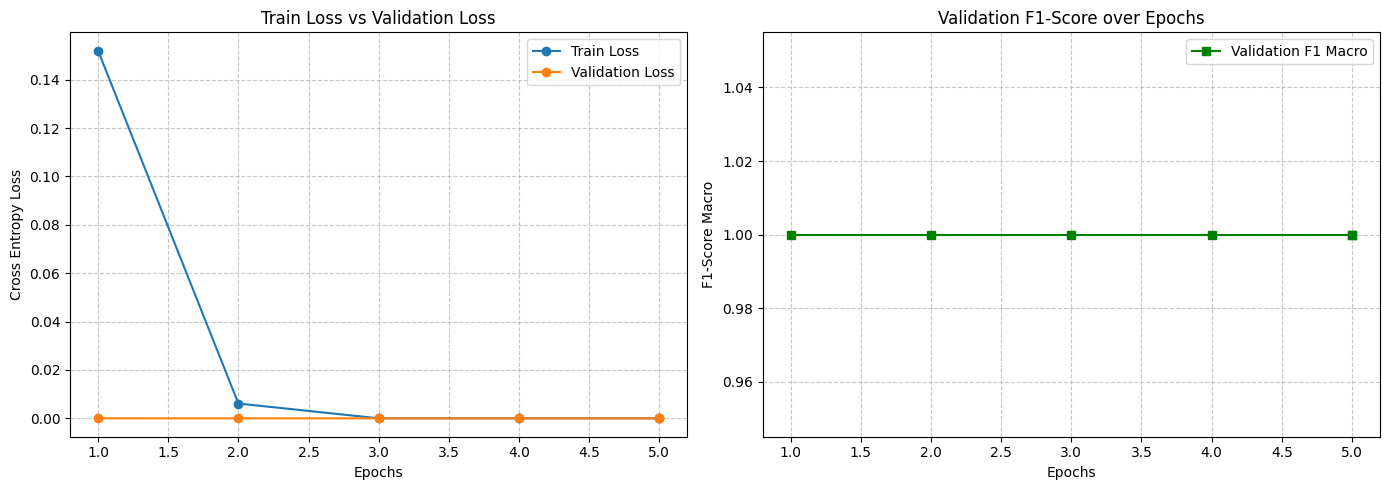

In [ ]:
# Processar o histórico do melhor modelo
train_loss, val_loss = [], []
train_epochs_loss, val_epochs = [], []

val_f1 = []

for log in best_log_history:
    if 'loss' in log:
        train_loss.append(log['loss'])
        train_epochs_loss.append(log['epoch'])
    if 'eval_loss' in log:
        val_loss.append(log['eval_loss'])
        val_f1.append(log['eval_f1_macro'])
        val_epochs.append(log['epoch'])

# Plot
plt.figure(figsize=(14, 5))

# Gráfico 1: Loss
plt.subplot(1, 2, 1)
plt.plot(train_epochs_loss, train_loss, label='Train Loss', marker='o')
plt.plot(val_epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Gráfico 2: F1-Score (Val)
plt.subplot(1, 2, 2)
plt.plot(val_epochs, val_f1, label='Validation F1 Macro', marker='s', color='green')
plt.title('Validation F1-Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-Score Macro')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Interpretação dos Gráficos
Os gráficos mostram a ausência de *overfitting*: enquanto a Train Loss continua caindo, a Validation Loss permanceu consistentemente baixo, indicando que o modelo manteve sua capacidade de generalização. O Early Stopping não foi ativado devia a microscópica melhora do Validation Loss.

## Avaliação Final no Conjunto de Teste
Carregamos o melhor modelo salvo do Google Drive e testamos numa partição nunca antes vista. Isto garante que não houve viés de otimização contínua (Validation Leakage).

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

Realizando inferência no conjunto de Teste...



📊 CLASSIFICATION REPORT (CONJUNTO DE TESTE)
              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      1699
    Fake (1)       1.00      1.00      1.00       521

    accuracy                           1.00      2220
   macro avg       1.00      1.00      1.00      2220
weighted avg       1.00      1.00      1.00      2220



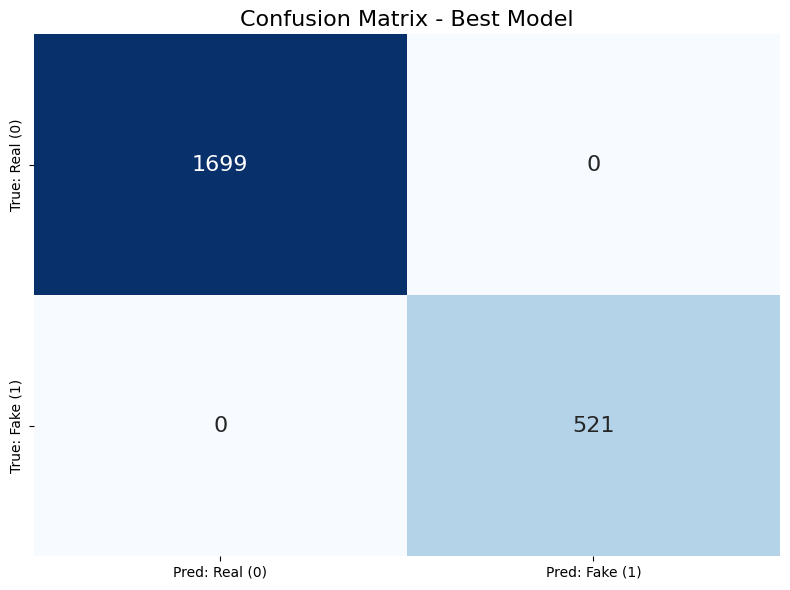


🚀 ROC-AUC FINAL (Teste): 1.0000
📉 Loss FINAL (Teste): 0.0000


In [ ]:
USAR_DOWNLOAD_ZIP = True # Mude para True se desejar utilizar a Opção 2

if not USAR_DOWNLOAD_ZIP:
  # Carregando o modelo salvo localmente no Drive

  '''
  Caso tenha executado o Treinamento anteriormente e o seu Drive
  esteja montado, use o caminho local.
  '''

  best_model = AutoModelForSequenceClassification.from_pretrained(best_model_path)
  best_tokenizer = AutoTokenizer.from_pretrained(best_model_path)

else:
  # --- Carregando o modelo via compartilhamento Online (.zip) ---
  url_modelo_zip = 'https://drive.google.com/uc?id=1-pIef8Yzp-Ii-GJI_4CE6Tfw1lpPthRV'
  output_zip = 'best_distilroberta_model.zip'
  extracted_folder = './best_nlp_model_online' # Pasta onde os arquivos serão extraídos no Colab

  try:
      # 1. Baixar o arquivo ZIP
      if not os.path.exists(output_zip):
          print("Baixando o modelo do Google Drive (isto pode demorar alguns segundos)...")
          gdown.download(url_modelo_zip, output_zip, quiet=False)

      # 2. Extrair o arquivo ZIP
      # Usamos try/except dentro da extração para garantir que a pasta seja criada corretamente
      if not os.path.exists(extracted_folder):
          print("📦 Extraindo os arquivos do modelo...")
          with zipfile.ZipFile(output_zip, 'r') as zip_ref:
              zip_ref.extractall(extracted_folder)
      print("\n✅ Download e extração concluídos com sucesso!")
  except Exception as e:
      print(f"❌ Erro ao baixar/extrair o modelo: {e}")

      # 3. Carregar o modelo e o tokenizer a partir da pasta extraída localmente
  caminho_do_modelo = extracted_folder
  for root, dirs, files in os.walk(extracted_folder):
      if 'config.json' in files:
          caminho_do_modelo = root
          break # Achou a pasta certa, pode parar de procurar!



  print(f"🧠 Carregando a arquitetura e os pesos do caminho real: {caminho_do_modelo}...")
  best_model = AutoModelForSequenceClassification.from_pretrained(caminho_do_modelo)
  best_tokenizer = AutoTokenizer.from_pretrained(caminho_do_modelo)

  print("🚀 Modelo e Tokenizer prontos para inferência!")

  # ---

# Precisamos instanciar um trainer simples apenas para predição
test_trainer = Trainer(
    model=best_model,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Prevendo no Dataset de Teste
print("Realizando inferência no conjunto de Teste...")
test_predictions = test_trainer.predict(tokenized_test)

preds = np.argmax(test_predictions.predictions, axis=1)
labels = test_predictions.label_ids

# Relatório de Classificação
print("\n" + "="*50)
print("📊 CLASSIFICATION REPORT (CONJUNTO DE TESTE)")
print("="*50)
print(classification_report(labels, preds, target_names=["Real (0)", "Fake (1)"]))

# Matriz de Confusão
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred: Real (0)", "Pred: Fake (1)"],
            yticklabels=["True: Real (0)", "True: Fake (1)"],
            cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix - Best Model', fontsize=16)
plt.tight_layout()
plt.show()

# ROC-AUC Final e Loss
probs = torch.nn.functional.softmax(torch.tensor(test_predictions.predictions), dim=-1)[:, 1].numpy()
roc_auc_final = roc_auc_score(labels, probs)
test_loss = test_predictions.metrics['test_loss']
print(f"\n🚀 ROC-AUC FINAL (Teste): {roc_auc_final:.4f}")
print(f"📉 Loss FINAL (Teste): {test_loss:.4f}")

### **Veredito Final**

No conjunto de teste (2.220 amostras, sendo 1.699 notícias reais e 521 falsas), o modelo atingiu desempenho máximo: **accuracy, precision, recall e F1-Score iguais a 1.00 para ambas as classes**, além de **ROC-AUC = 1.0000** e **loss = 0.0000**. Isso demonstra que o modelo manteve performance perfeita mesmo em dados nunca vistos, evidenciando forte capacidade de generalização dentro deste dataset. Em comparação com o DistilBERT, que já havia apresentado resultados excelentes, o DistilRoBERTa obteve métricas superiores no teste final, consolidando-se como o modelo campeão da tarefa 🏆. A arquitetura conseguiu capturar com precisão os padrões linguísticos que diferenciam notícias reais de falsas, enquanto o cuidado no pré-processamento e na análise exploratória garantiu previsões fundamentadas no conteúdo semântico, sem indícios de atalho ou vazamento de informação. Trata-se de um classificador altamente robusto e tecnicamente preparado para aplicação prática neste contexto.

## Exportação e Próximos Passos
O melhor modelo já está salvo em `/content/drive/MyDrive/PS_Ligia_NLP/best_nlp_model`.
Com os ficheiros `pytorch_model.bin` e `config.json`, juntamente com os ficheiros do Tokenizer, este modelo está pronto para Produção (Deploy) usando FastAPI, Streamlit, ou o Hugging Face Inference API.